In [38]:
import pyro
import torch
import torch.nn as nn
import numpy as np
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import matplotlib.pyplot as plt
from pyro.infer import MCMC, NUTS
from pyro.infer import Predictive
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [26]:
# Creating dataset
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)
# X, X_test, y, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [47]:
# Generate a blob dataset
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42, cluster_std=2.5)

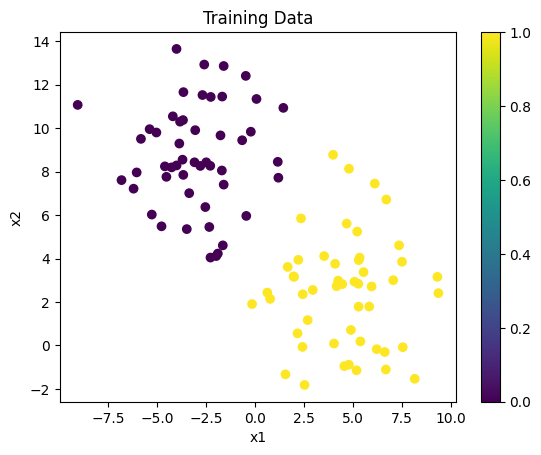

In [48]:
# Plotting the dataset
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Training Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()

In [49]:
# Defining the logistic regression model using pyro
def logistic_regression(X, y = None):
    # Defining the weights and bias
    w = pyro.sample("w", dist.Normal(0., 10.).expand([2]).to_event(1))
    b = pyro.sample("b", dist.Normal(0., 10.))
    # Defining the linear model
    f = torch.matmul(X, w) + b
    # Defining the probability of y = 1
    p = torch.sigmoid(f)
    # Sampling the label
    with pyro.plate("data", X.shape[0]):
        y = pyro.sample("y", dist.Bernoulli(p), obs=y)
    return y

In [50]:
# Defining the NUTS kernel and MCMC
lgreg_nuts_kernel = NUTS(logistic_regression)
lgreg_mcmc = MCMC(lgreg_nuts_kernel, num_samples=1000, warmup_steps=500)

In [51]:
# Running the MCMC
lgreg_mcmc.run(torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float))

Sample: 100%|██████████| 1500/1500 [00:45, 33.22it/s, step size=1.64e-01, acc. prob=0.830]


In [52]:
# Getting samples from the posterior
lgreg_posterior = lgreg_mcmc.get_samples()

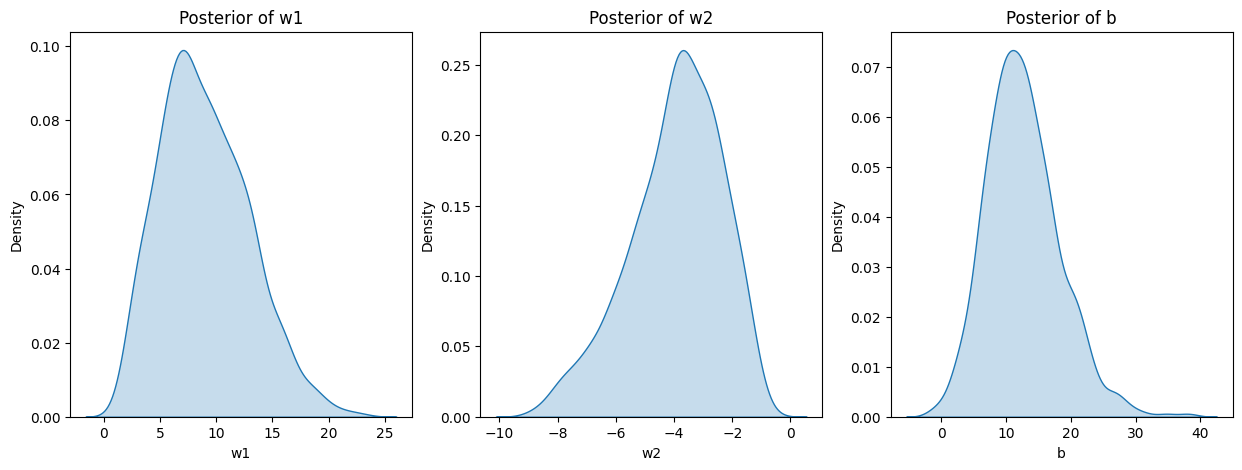

In [53]:
# Plotting the kde plot of the posterior for each parameter of the model separately using subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(lgreg_posterior["w"][:,0], ax=axes[0], fill=True)
axes[0].set_title("Posterior of w1")
axes[0].set_xlabel("w1")
sns.kdeplot(lgreg_posterior["w"][:,1], ax=axes[1], fill=True)
axes[1].set_title("Posterior of w2")
axes[1].set_xlabel("w2")
sns.kdeplot(lgreg_posterior["b"], ax=axes[2], fill=True)
axes[2].set_title("Posterior of b")
axes[2].set_xlabel("b")
plt.show()


In [54]:
# Predictive distribution
predictive = Predictive(logistic_regression, lgreg_posterior)

In [57]:
# Get the min and max values of the dataset
x1_min, x1_max = X[:,0].min(), X[:,0].max()
x2_min, x2_max = X[:,1].min(), X[:,1].max()

In [58]:
# Getting the predictions over a grid of points
X1, X2 = np.meshgrid(np.linspace(x1_min + 0.5, x1_max + 0.5, 100), np.linspace(x2_min + 0.5, x2_max + 0.5, 100))
X_grid = torch.tensor(np.c_[X1.ravel(), X2.ravel()], dtype=torch.float)
y_grid = predictive(X_grid)["y"]

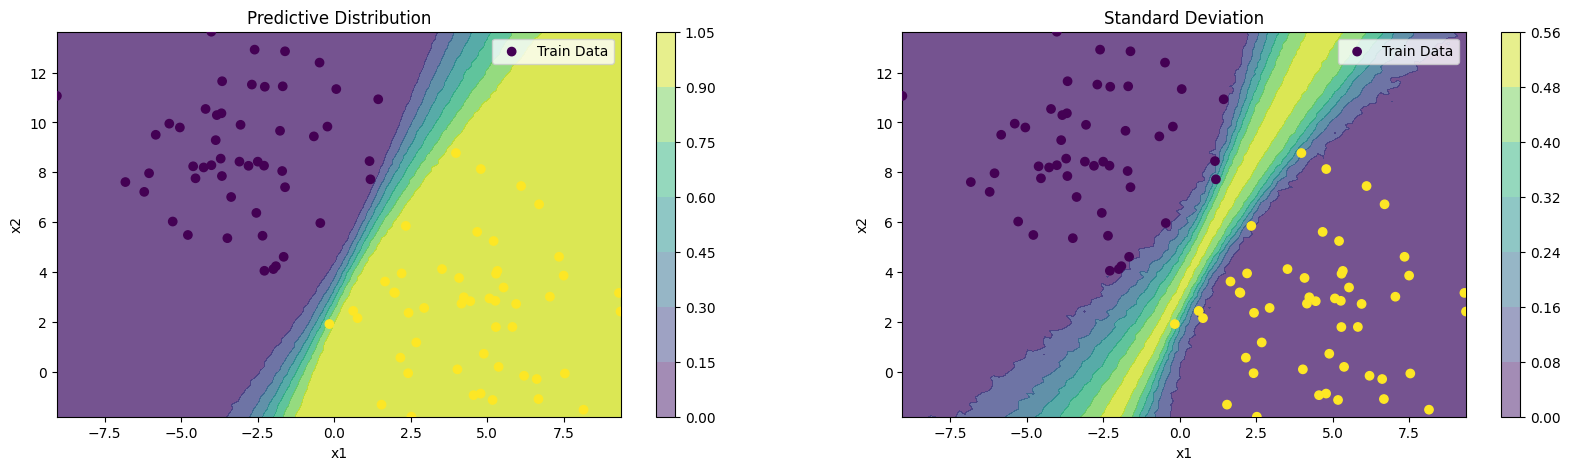

In [59]:
# Create 2 subplots for mean and std
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.contourf(X1, X2, y_grid.mean(axis=0).reshape(X1.shape), alpha=0.5)
ax1.scatter(X[:,0], X[:,1], c=y, marker = 'o', label = 'Train Data', zorder = 100)
ax1.set_title("Predictive Distribution")
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.legend()
ax2.contourf(X1, X2, y_grid.std(axis=0).reshape(X1.shape), alpha=0.5)
ax2.scatter(X[:,0], X[:,1], c=y, marker = 'o', label = 'Train Data', zorder = 100)
ax2.set_title("Standard Deviation")
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.legend()
fig.colorbar(ax1.contourf(X1, X2, y_grid.mean(axis=0).reshape(X1.shape), alpha=0.5), ax=ax1)
fig.colorbar(ax2.contourf(X1, X2, y_grid.std(axis=0).reshape(X1.shape), alpha=0.5), ax=ax2)
plt.show()

### Observation

pyro.sample takes in 'obs' which is used as the true values during inference to adjust the parameters of our distribution/function. However, for unlearning purposes, we cannot give an 'obs' to be used as a reference since internally it equates the values. For unlearning, we want them not to be equal. For the case of binary classification, one can give the opposite case, which might mimic the results of unlearning, but this has its flaws. Fundamentally, it does not remove points, rather learns the same points with updated 'y' values. The results of unlearning as such and retraining on the retained data will not be the same.

#### Splitting dataset into del and ret

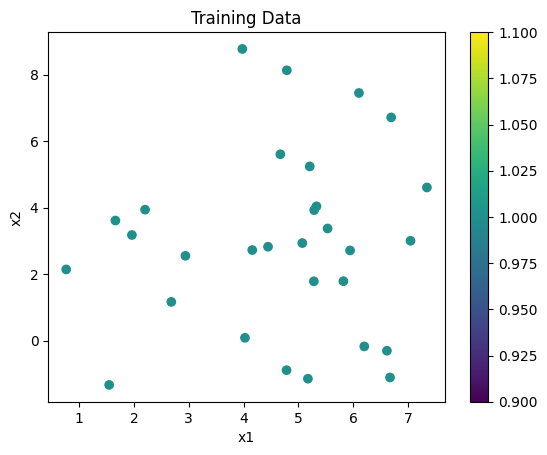

In [71]:
# Remove the first 30 samples whose y value is 0
X_new = X[y != 0]
y_new = y[y != 0]

# Split the dataset into subset of size 30 and 20
X_del = X_new[:30]
y_del = y_new[:30]

X_add = X_new[30:]
y_add = y_new[30:]

# Plotting the dataset
plt.scatter(X_del[:,0], X_del[:,1], c=y_del)
plt.title("Training Data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()